# Feature Importance
### Introduction
- It is desirable to be able to interpret the reasons for certain model predictions
- Which feature contribute the most to the prediction seen?


In [30]:
# https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/feature_importance.ipynb
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [32]:
boston = load_boston()
y = boston.target
X = pd.DataFrame(boston.data, columns = boston.feature_names)
np.random.seed(seed = 42)
X['random'] = np.random.random(size = len(X))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42)

- Notice the addition of random column
- We expect this to have low predictive power

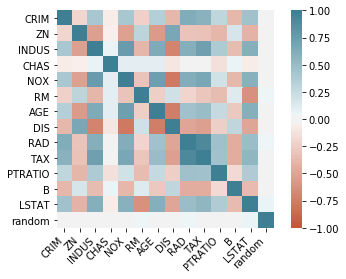

In [33]:
corr = X.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Benchmark Model
- plain Random Forest model


In [34]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))

R^2 Training Score: 0.93 
OOB Score: 0.58 
R^2 Validation Score: 0.76


- overfitting (worse on OOB and Validation)
- but we ignore this and move forward first

## 1. Overall feature importances
- derived at the model level i.e. which features are regarded as the most important features by THIS model
### 1.1. Default Scikit-learn's feature importances
- which features contributes to decreasing impurity?

Pros:
- fast calculation
- easy to retreive

Cons:
- biased approach: tend to inflate the importance of continous features or high cardinality categorical variables

In [35]:
base_imp = imp_df(X.columns, rf.feature_importances_)
print(base_imp)

    feature  feature_importance
0        RM            0.422139
1     LSTAT            0.304657
2       DIS            0.073838
3      CRIM            0.067455
4   PTRATIO            0.026696
5       NOX            0.021175
6         B            0.019827
7       AGE            0.018577
8       TAX            0.017824
9    random            0.010901
10    INDUS            0.007950
11      RAD            0.004680
12       ZN            0.002625
13     CHAS            0.001657


### 1.2. Permutation feature importance
- observing how random re-shuffling of each predictor influences model performance
Steps
1. Train baseline model and record the score
2. Re-shuffle values from one feature in the selected dataset, pass the dataset to the model again to obtain prediction, calculate metric. The feature importance is the difference between the benchmark score and the one from the modified dataset. 

Pros: 
- Applicable to any model
- Reasonably efficient
- Reliable technique
- No need to retrain model at each modification of the dataset

Cons:
- More computationally expensive than the default feature_importance
- Permutation importance overestimates the importance of correlated predictors - Strobl et al (2008)

### 1.3. Drop Column feature importance
- compare a model with all features versus a model with this feature dropped for training

In [36]:
from sklearn.base import clone
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

CPU times: user 4.61 s, sys: 685 ms, total: 5.3 s
Wall time: 6.39 s
    feature  feature_importance
0     LSTAT            0.020829
1        RM            0.006777
2        ZN            0.000913
3     INDUS            0.000756
4      CHAS            0.000715
5       NOX            0.000526
6       TAX            0.000175
7   PTRATIO            0.000154
8      CRIM            0.000083
9         B           -0.000985
10      RAD           -0.001449
11      AGE           -0.001675
12   random           -0.002788
13      DIS           -0.005193


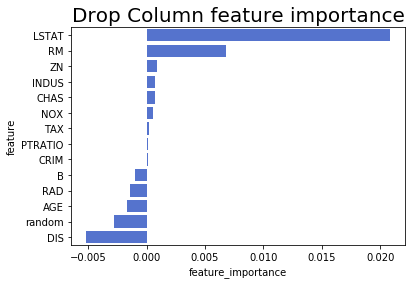

In [37]:
rf.fit(X_train, y_train)
%time drop_imp = drop_col_feat_imp(rf, X_train, y_train)
print(drop_imp)
var_imp_plot(drop_imp, 'Drop Column feature importance')

# Reference
- https://medium.com/analytics-vidhya/ranking-features-based-on-importance-predictive-power-with-respect-to-the-class-labels-of-the-25afaed71e90
- https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
- https://explained.ai/rf-importance/#5